<a href="https://colab.research.google.com/github/tedteske/Covid-19-Model/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction

This set of functions plots the path of the Covid-19 pandemic and provides tools for constructing what-if scenarios. We make use of the following publicly available datasets: 

For country-level case and population data, see https://ourworldindata.org/coronavirus-source-data. Data files:
* https://covid.ourworldindata.org/data/owid-covid-data.csv
* https://covid.ourworldindata.org/data/ecdc/locations.csv

For U.S. state-level case and population data
* https://github.com/nytimes/covid-19-data
* https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html


We forecast each day's new confirmed cases according to the formula:

$ c_t = contagious_{t-1} \times R_{0,t}/days_{contagious} \times (1 - immune_{t-1}) $

where
* $ c_t = \text{new confirmed casess at time t} $
* $ C_t = \text{cumulative confirmed cases at time t} $
* $ contagious_t = C_t - C_{t - days_{contagious}}$
* $ R_{0,t} = \text{basic reproduction number} \geq 0$
* $ days_{contagious} = \text{number of days each case is assumed to be contagious} = 14 \text{, by default}$
* $ immune = \text{fraction of the population that is immune} = prevalence/(1 - unreported)$
* $ prevalance = \text{cumulative confirmed cases as a fraction of the total population} = C_t/population$
* $ unreported = \text{fraction of all cases that are not reported} $


Given historical data to time $t-1$, all of the above terms are endogenous to the model except for the [basic reproduction number](https://en.wikipedia.org/wiki/Basic_reproduction_number) $R_{0,t}$ and the assumed constant $ days_{contagious}$.

We assume that the path of $R_0$ follows an S-shaped curve from the most recent $R_0$ to some target. 

$R_{0,t}=f(x)= \frac{R_{0,target}-R_{0,t-1}}{1 + e^{(-k \times (x - offset)}}+R_{0,t-1}$

where
* $R_{0,target} = \text{assumed target basic reproduction number}$
* $e = \text{base of the natural logarithm} \approx 2.71828$
* $offset = x \text{ value of the sigmoid's midpoint, default 0}$
* $k = \text{logistic growth rate or steepness of the curve, default 1}$
* $x = \text{real number in the closed interval -6 to 6}$

This is adapted from logistic curve as described at https://en.wikipedia.org/wiki/Logistic_function.

To generate a path for $R_0$, we evenly divide the closed interval -6 to 6 by the number of days we assume it will take to get from $R_{0,t-1}$ to $R_{0,target}$ and plug results into the formula as $x$. Rather than merely assuming the number of days, we can take the average daily rate of progress toward in $R_{0,target}$ over the last several days, say one week.

$r_\Delta = \overline{\% \Delta (R_{0,target} - R_{0,t})}$

and calculate the number of days to get from $R_{0,t-1}$ to $R_{0,target}$:

$days = \log_{1+r_\Delta}(2)=\ln(2)/\ln(1+r\Delta) \text{, rounded}$

This assumes that recent daily percent progess holds in the near future.


## Loading Functions and Data. Run these first.

Run imports and functions.

In [0]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

import pandas as pd
import math
from datetime import date
import numpy as np
import seaborn as sns 
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None  # default='warn'
sns.set(style='darkgrid') 
plt.rcParams["font.family"] = "serif"
plt.rcParams["figure.figsize"] = [13, 13/1.6]


def load_df(covid_data, pop_data, case_start=10, contagious_days=14):
    '''
    Loads covid_data into new dataframe, merges population and continent fields 
    from pop_data, and passes to munge_data() and order_columns() for
    further processing. This is the first function called after importing
    CSV files.

    Parameters
    ----------
    covid_data (pd.DataFrame) : raw data from Covid-19 CSV file [1] or similar
    pop_data (pd.DataFrame) : raw data from population CSV file [2] or similar
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    
    Notes
    ----
    [1] https://covid.ourworldindata.org/data/ecdc/full_data.csv
    [2] https://covid.ourworldindata.org/data/ecdc/locations.csv
    '''
    try:
        population_cols = ['location', 'continent', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
    except:
        population_cols = ['location', 'population']
        latest_pops = pop_data[population_cols].groupby('location').max()
        covid_data = covid_data.merge(latest_pops, 
                                      left_on='location', right_on='location')
        covid_data['continent'] = 'NA'
    covid_data.rename(columns={'continent': 'region'}, inplace=True) 
    df = munge_data(covid_data, case_start, contagious_days)
    df = order_columns(df)
    return df


def munge_data(df, case_start, contagious_days):
    '''
    Indexes dataframe by location and date, and creates all calculated fields.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe to be processed
    case_start (int) : minimum total cases, below which records are not loaded 
    contagious_days (int) : number of days infected person assumed contagious      

    Returns
    -------
    pd.DataFrame
    '''

    df = df.copy()
    df['date'] = pd.to_datetime(df['date'])
    df['contagious_days'] = contagious_days

    df.set_index(['location', 'date'], inplace=True)
    df['day'] = df.index.get_level_values('date').day_name().str.slice(stop=3)
    df.index.names = ['location', None]
    
    df['source'] = 'actual'
    df['prevalence'] = df['total_cases']/df['population']       
    
    df['contagious'] = (df['total_cases'] 
                        - df['total_cases'].shift(contagious_days))
    df.loc[df['contagious'] < 0, 'contagious'] = df.loc[df['contagious'] < 0, 
                                                        'total_cases']
    
    df['R_zero'] = df['new_cases']/df['contagious'] * contagious_days
    
    np.seterr(divide = 'ignore') 
    '''
    Otherwise, get "RuntimeWarning: divide by zero encountered in log result".
    Warning happens when np.log(0), for example when total_cases declines 100%.
    As total_cases is cumulative and gross of recovered, this example could 
    only happen with a reporting agency error. 
    
    Better to ignore this RuntimeWarning, and leave the public data unaltered.
    '''
    df['growth'] = np.log(1 + df['total_cases'].pct_change())
    df['days_to_dbl'] = np.log(2)/df['growth']
    df.loc[df.groupby('location').head(1).index,
           ['growth', 'days_to_dbl']] = np.NaN
    np.seterr(divide = 'warn') 
    
    df['fatality'] = df['total_deaths']/df['total_cases']
    
    return df


def order_columns(df):
    '''
    Re-orders dataframe columns after each load and forecast.
    '''

    column_names = ['day', 'new_cases',  'total_cases', 'prevalence', 
                    'growth', 'days_to_dbl', 'contagious', 'R_zero',  
                    'new_deaths', 'total_deaths', 'fatality', 
                    'total_tests', 'new_tests',
                    'source', 'population', 'region']
    return df.reindex(columns=column_names)
   

def create_R_zero_path(days, last, move=[]):
    '''
    Creates a path of future reproduction numbers to be used in forecast().

    Parameters
    ----------
    days (int) : number of days forecasted
    last (float) : starting reproduction number 
    move[0] (float) : target reproduction number 
    move[1] (float) : daily rate of change from last to target       
    move[2] (float) : default 0; offset or x_0, 
                    the x value of the sigmoid's midpoint [1]
    move[3] (float) : default 1; k, the logistic growth rate 
                    or steepness of the curve [1]

    Returns
    -------
    pd.Series: series of forecast reproduction numbers
    
    Notes
    -----
    [1] https://en.wikipedia.org/wiki/Logistic_function
    [2] https://en.wikipedia.org/wiki/Sigmoid_function
    [3] https://ibguides.com/biology/notes/populations/
    '''
    
    if isinstance(move, (int, float)):
        move = [move]

    move_full_spec = [last, None, 0, 1]
    move_full_spec[:len(move)] = move
    target, rate, offset, k = move_full_spec
    
    if rate:
        days_motion = int(round(np.log(2)/np.log(1 + rate)))
    else:
        days_motion = days
    
    L = target - last

    y = []
    for x in np.linspace(-6, 6, days_motion):
        fx = L / (1 + math.e**(-k * (x - offset)))
        fx += last
        y.append(fx)
    
    days_flat = max(days - days_motion, 0)
    flat_values = np.ones(days_flat) * y[-1]
    y = y + list(flat_values)
    return pd.Series(y)


def forecast(df, days, R_zero_move=[], R_zero_trailing=1, 
             new_R_zeros=None, new_fatality=None,
             unreported=0.0, contagious_days=14, replace=True):
    '''
    Forecasts reproduction numbers.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe of inputs to forecast
    days (int) : number of days forecasted
    R_zero_move (list of floats) : parameters for reproduction number motion
        see create_R_zero_path() docstring for details on list items
    R_zero_trailing (int > 0) : number of most recent R_zero 
        over which to average
    new_R_zeros (None or list or Series of floats) : forward path of R-zero;
        if not None, ignore R_zero_move and R_zero_trailing
    new_fatality (float) : forward case fatality rate; if None, uses last
    unreported (float) : portion of total contagious that goes unreported, 
        between 0 and 1
    contagious_days (int) : number of days infected person assumed contagious
    replace (bool) : if True, replace existing forecast records

    Returns
    -------
    pd.DataFrame: dataframe with appended forecast records
    '''

    if replace:
        df = df[df['source'] != 'forecast']
    
    if days > 0:        
        
        if new_R_zeros is None:
            last_R_zero = df['R_zero'][-R_zero_trailing:].mean()
            new_R_zeros = create_R_zero_path(days, last_R_zero, R_zero_move)
        
        for i in range(days):

            last = df.iloc[-1]
            R_zero_ = new_R_zeros[i]  
            trans_rate = last['R_zero']/contagious_days

            # adjust for herd immunity
            immune = last['prevalence']/(1 - unreported)

            new_cases_ = last['contagious'] * trans_rate * (1 - immune)
            total_cases_ = last['total_cases'] + new_cases_
            prevalence_ = total_cases_/last['population']
            contagious_ = (total_cases_ 
                           - df.iloc[-contagious_days]['total_cases'])
                     
            growth_ = np.log(total_cases_/last['total_cases'])
            days_to_dbl_ = np.log(2)/growth_
            
            if new_fatality is None:
                fatality_ = last['fatality']
            else:
                fatality_ = new_fatality[i]
                  
            total_deaths_ = total_cases_ * fatality_
            new_deaths_ = total_deaths_ - last['total_deaths']

            data = {'source': 'forecast',
                    'new_cases': new_cases_,
                    'total_cases': total_cases_,
                    'prevalence': prevalence_,
                    'R_zero': R_zero_,
                    'contagious': contagious_,
                    'growth': growth_,
                    'days_to_dbl': days_to_dbl_,
                    'new_deaths': new_deaths_,
                    'total_deaths': total_deaths_,
                    'fatality': fatality_,
                    'population': last['population'],
                    'region': last['region']}
            
            next_date = df.index[-1] + pd.Timedelta(days=1)
            df = df.append(pd.DataFrame(data, index=[next_date]))
        
        df['day'] = df.index.day_name().str.slice(stop=3)
        df = order_columns(df)
    return df


def plot_timeline(df, title=None, date_freq='MS',
                  left=[],
                  right=None,
                  left_ylabel=None,
                  right_ylabel=None,
                  left_yscale=1000):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis, maximum 2
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    data = df.copy()
    
    fig, ax = plt.subplots()
    fig_width = 20
    fig.figsize = (fig_width, fig_width/1.6)
   
    for column in left:
        sns.lineplot(x=data.index, y=column, style='source', data=data, 
                     legend=False, ax=ax)
    b = min(len(ax.lines)-1, 2)
    
    # configure right axis
    if right:
        ax2 = ax.twinx()
        sns.lineplot(x=data.index, y=right, style='source', data=data,
                     legend=False, ax=ax2, color='g')
        
        yticks = np.arange(data[right].min(), data[right].max(), 0.5)
        yticks = (yticks * 2).round()/2  # limits yticks to multiples of 0.5
        
        ax2.set_yticks(yticks)
        if right_ylabel:        
            ax2.set_ylabel(right_ylabel)
        else:
            ax2.set_ylabel(right)
        handles = [ax.lines[a] for a in [0, b]] + [ax2.lines[0]]
        labels = left + [right]
    
    else:
        handles = [ax.lines[a] for a in [0, b]] 
        labels = left 
   
    ax.legend(handles, labels, loc=0)

    # configure xticks
    xticks = pd.date_range(start=data.index.min(), 
                           end=data.index.max(),
                           freq=date_freq)
    ax.set_xticks(xticks)

    # configure ylabels, yticks
    if left_ylabel:
        ax.set_ylabel(left_ylabel) 
    else:
        ax.set_ylabel(str(left) + ' (thousands)')
    ax.set_yticklabels(ax.get_yticks()/left_yscale)

    plt.title(title)
    plt.show()


def plot_cdr(df, title=None, date_freq='MS',
             left=['total_deaths', 'new_cases'],
             right='R_zero',
             left_ylabel='cases, deaths (thousands)',
             right_ylabel='reproduction number (or R-zero)',
             left_yscale=1000):
    '''
    Lineplots time series of Total Deaths, New Cases, and Reproduction Numbers,
    appropriately scaled, using plot_timeline().

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    title (str) : plot title
    date_freq (str) : x-axis tick freqency, to prevent cluttering 
        'MS' for month start
        'W' for weekly
        'Q' for quarterly
    left (list of str) : names of columns to be plotted using left axis
    right (str) : name of column to be plotted using right axis
    left_ylabel (str) : left axis label
    right_ylabel (str) : right axis label
    left_yscale (int) : scale of left axis tick labels
    '''
    
    plot_timeline(df, title=title, date_freq=date_freq,
                  left=left,
                  right=right,
                  left_ylabel=left_ylabel,
                  right_ylabel=right_ylabel,
                  left_yscale=left_yscale)


def plot_growth(df, locations, column='total_cases', title=None, 
                start=10, ascending=True, rolling=1, logy=True,
                min_cases=10, hline=None):
    '''
    Lineplots several user-defined time series.

    Parameters
    ----------
    df (pd.DataFrame) : dataframe with columns to be plotted
    locations (list of str) : names of locations to be plotted
    column (str) : name of column to be plotted for each location
    title (str) : plot title
    start (int) : starting value for the plotted column
    ascending (bool) : if True, plot values above start; if False, below
    rolling (int) : days over which to apply a rolling mean
    logy (bool) : if True, configure y-axis as a log(10) scale
    min_cases (int) : minimum threshold total_cases; 
                      ignored if column='total_cases'
    hline (float or None) : if float, plot horizontal line

    Note
    ----
    The parameter min_cases is especially useful when plotting R_zero, as
    early R_zero values are highly variable.
    '''
    
    data = df.copy()
    
    # apply rolling mean to each location
    data = data.groupby(level=0).rolling(rolling).mean()
    
    # unless plotting total_cases itself, apply a total_cases threshold
    if column != 'total_cases':
        data = data[data['total_cases'] >= min_cases]
    
    if ascending:
        data = data[data[column] >= start]
    else:
        data = data[data[column] <= start]        

    # create column representing days since cutoff values
    data['days_since'] = data.groupby(level=0).cumcount()
    data.loc[data['days_since'] == 0, column] = start
    
    # move location to column, then pivot
    data.reset_index(level=1, inplace=True) 
    pivoted = data.pivot(index='days_since', columns='location', values=column)
    pivoted.index.name = "days since " + column + " = " + str(start) 

    pivoted[locations].plot(logy=logy, title=title or column)

    if hline:
        plt.axhline(hline, ls='-', color='gray', alpha=0.7)
    
    plt.show()

Load country and U.S. state-level data from public sources.

In [0]:
'''
Load country-level data from https://covid.ourworldindata.org
'''

covid_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/full_data.csv')
#covid_data = pd.read_csv('https://covid.ourworldindata.org/data/owid-covid-data.csv')
pop_data = pd.read_csv('https://covid.ourworldindata.org/data/ecdc/locations.csv')
df = load_df(covid_data, pop_data, case_start=1, contagious_days=14)

In [0]:
'''
Load US state-level data from 
https://github.com/nytimes/covid-19-data
https://www.census.gov/data/tables/time-series/demo/popest/2010s-state-total.html
'''

covid_state_data =  pd.read_csv('https://raw.githubusercontent.com/nytimes/'
                                'covid-19-data/master/us-states.csv')

covid_state_data.rename({'state':'location', 'cases':'total_cases', 
                         'deaths':'total_deaths'}, axis='columns', inplace=True) 
covid_state_data.drop('fips', axis='columns', inplace=True) 

covid_state_data.set_index(['location','date'], inplace=True)
covid_state_data.sort_index(inplace=True)
covid_state_data['new_cases'] = np.nan 
covid_state_data['new_deaths'] = np.nan 

for idx in covid_state_data.index.levels[0]:
    covid_state_data.new_cases[idx] = covid_state_data.total_cases[idx].diff()
    covid_state_data.new_deaths[idx] = covid_state_data.total_deaths[idx].diff()

covid_state_data.reset_index(inplace=True)

pop_state_data = pd.read_csv('http://www2.census.gov/programs-surveys/popest/'
                            'datasets/2010-2019/national/totals/'
                            'nst-est2019-popchg2010_2019.csv')
pop_state_data = pop_state_data[['NAME', 'POPESTIMATE2019']]

pop_state_data.rename({'NAME':'location', 'POPESTIMATE2019':'population'}, 
                      axis='columns', inplace=True) 

df_states = load_df(covid_state_data, pop_state_data,  
                    case_start=10, contagious_days=14)

## United States

This is the last one week.

In [74]:
US_Cov = df[df['total_cases']>100].loc['United States']
US_Cov[US_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-07,Thu,24128,1228603,0.003712,0.019834,34.947486,385974.0,0.875168,2353,73431,0.059768,NaN,NaN,actual,331002647.0,North America
2020-05-08,Fri,28369,1256972,0.003797,0.022828,30.364033,387800.0,1.024152,2239,75670,0.060200,NaN,NaN,actual,331002647.0,North America
2020-05-09,Sat,26957,1283929,0.003879,0.021219,32.665955,393405.0,0.959312,1510,77180,0.060112,NaN,NaN,actual,331002647.0,North America
2020-05-10,Sun,25612,1309541,0.003956,0.019752,35.092886,370488.0,0.967826,1614,78794,0.060169,NaN,NaN,actual,331002647.0,North America
2020-05-11,Mon,20258,1329799,0.004017,0.015351,45.152906,363889.0,0.779392,734,79528,0.059805,NaN,NaN,actual,331002647.0,North America
2020-05-12,Tue,18117,1347916,0.004072,0.013532,51.223224,359465.0,0.705599,1156,80684,0.059858,NaN,NaN,actual,331002647.0,North America
2020-05-13,Wed,22048,1369964,0.004139,0.016225,42.721551,357381.0,0.863706,1703,82387,0.060138,NaN,NaN,actual,331002647.0,North America


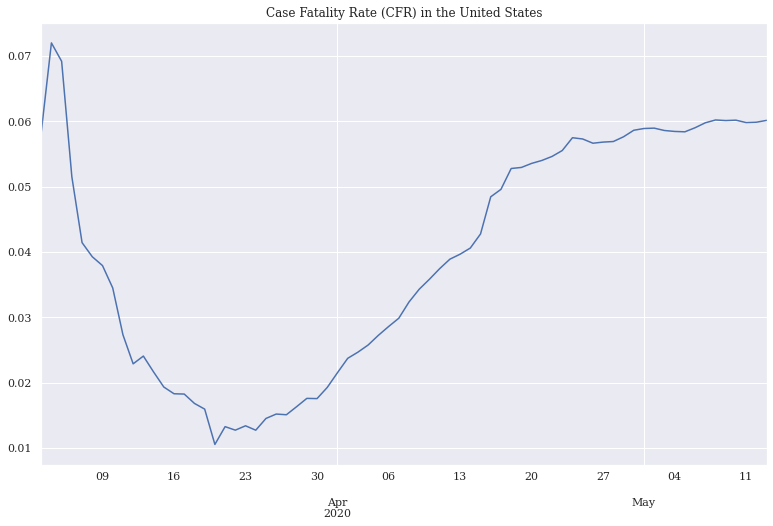

In [75]:
US_Cov[US_Cov['source']=='actual']['fatality'].plot(title='Case Fatality Rate (CFR) in the United States')
plt.show()

ValueError: ignored

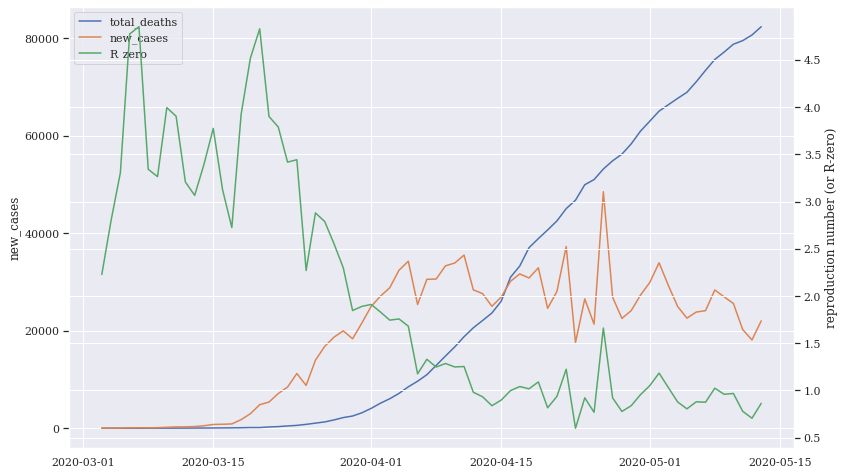

In [129]:
plot_cdr(US_Cov[US_Cov['source']=='actual'], 
         'Covid in the United States','W2')

Now let's forecast the next 100 days. Assume a daily percent change in the reproduction number and target of 0.7. Plug this estimate into forecast model, print the results, and plot.



In [77]:
US_Cov = forecast(US_Cov, 100, R_zero_move=[0.7, 0.05, 0], R_zero_trailing=7)
default_scenario = US_Cov.copy()
default_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-15,Sat,328.373287,1.887855e+06,0.005703,0.000174,3984.634379,6304.411303,0.70045,19.747738,113531.962191,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-16,Sun,313.624399,1.888169e+06,0.005704,0.000166,4172.730160,6021.255036,0.70045,18.860768,113550.822959,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-17,Mon,299.537990,1.888468e+06,0.005705,0.000159,4369.671082,5750.817403,0.70045,18.013639,113568.836598,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-18,Tue,286.084331,1.888754e+06,0.005706,0.000151,4575.872612,5492.527076,0.70045,17.204561,113586.041159,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-19,Wed,273.234996,1.889027e+06,0.005707,0.000145,4791.770167,5245.837994,0.70045,16.431827,113602.472986,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-20,Thu,260.962816,1.889288e+06,0.005708,0.000138,5017.820013,5010.228508,0.70045,15.693802,113618.166788,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-21,Fri,249.241838,1.889538e+06,0.005709,0.000132,5254.500106,4785.200506,0.70045,14.988925,113633.155713,0.060138,NaN,NaN,forecast,331002647.0,North America


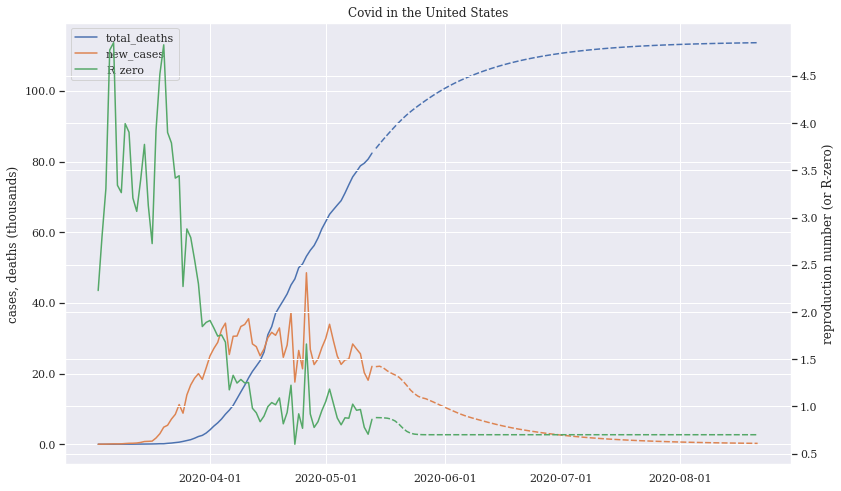

In [78]:
plot_cdr(default_scenario, 'Covid in the United States')

### Scenario: Relax on May 1 

In [79]:
forecast_days = 100
relax_date = date(2020, 5, 1) 
relax_days = 14

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relaxation period
US_Cov = forecast(US_Cov, stage_1, R_zero_move=[0.7, 0.05, 0], 
                  R_zero_trailing=7, replace=True)

stage_2 = relax_days # days during relaxation period
US_Cov = forecast(US_Cov, stage_2, R_zero_move=[1.0, None, 0], replace=False)

stage_3 = forecast_days - stage_1 - stage_2 # days during retrenchment
US_Cov = forecast(US_Cov, stage_3, R_zero_move=[0.7, 0.10,  0], replace=False)

relax_scenario = US_Cov.copy()
relax_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-27,Thu,299.280955,2.092849e+06,0.006323,0.000143,4846.778334,5746.923538,0.700741,17.998181,125859.895285,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-28,Fri,285.831592,2.093135e+06,0.006324,0.000137,5075.545444,5488.670114,0.700741,17.189362,125877.084647,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-29,Sat,272.986745,2.093408e+06,0.006324,0.000130,5315.074560,5242.023445,0.700741,16.416898,125893.501545,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-30,Sun,260.719209,2.093668e+06,0.006325,0.000125,5565.872490,5006.460956,0.700741,15.679152,125909.180697,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-31,Mon,249.002989,2.093917e+06,0.006326,0.000119,5828.470316,4781.483653,0.700741,14.974561,125924.155258,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-09-01,Tue,237.813264,2.094155e+06,0.006327,0.000114,6103.424278,4566.615239,0.700741,14.301632,125938.456890,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-09-02,Wed,227.126341,2.094382e+06,0.006327,0.000108,6391.316718,4361.401156,0.700741,13.658941,125952.115832,0.060138,NaN,NaN,forecast,331002647.0,North America


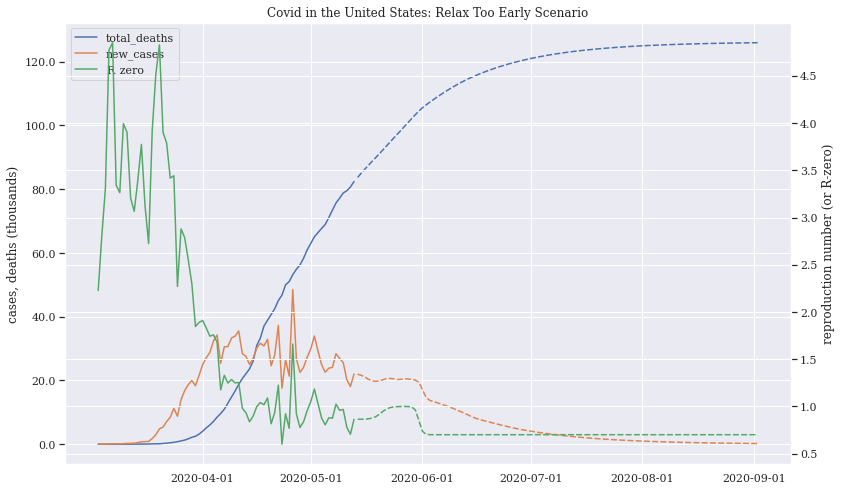

In [80]:
plot_cdr(relax_scenario, 'Covid in the United States: Relax Too Early Scenario')

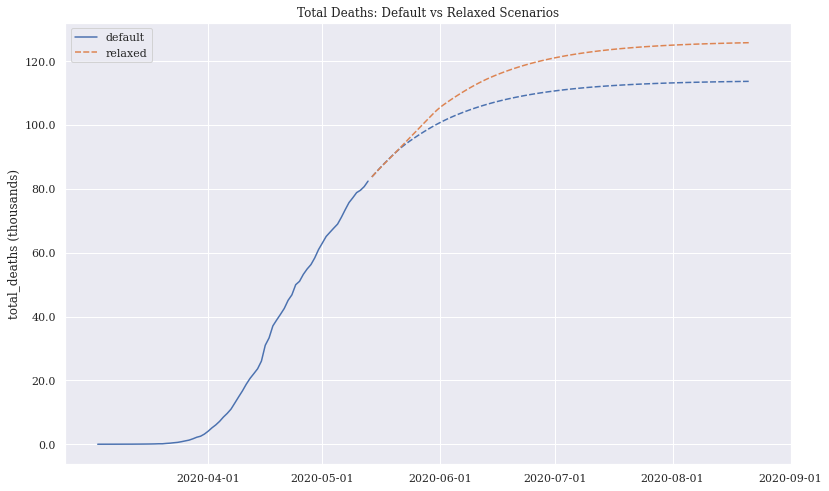

In [81]:
column = 'total_deaths'

relaxed = relax_scenario[relax_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, relaxed], axis=1)
compare.columns = ['default','source','relaxed']

plot_timeline(compare, 'Total Deaths: Default vs Relaxed Scenarios',
              date_freq='MS',
              left=['default','relaxed'], right=None,
              left_ylabel=column + ' (thousands)')

Alternately, we can relax and stay relaxed.

In [82]:
forecast_days = 100
relax_date = date(2020, 5, 1) 
relax_days = 7

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (relax_date - last_actual).days # days until start of relaxation period
US_Cov = forecast(US_Cov, stage_1, R_zero_move=[0.7, 0.05, 0], 
                  R_zero_trailing=7, replace=True)

stage_2 = forecast_days - stage_1 # days during relaxation period
US_Cov = forecast(US_Cov, stage_2, R_zero_move=[1.0, None, 0], replace=False)

US_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-27,Thu,7418.692657,2.511122e+06,0.007586,0.002959,234.273699,104610.267148,0.999357,446.145907,151014.031939,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-28,Fri,7410.705259,2.518532e+06,0.007609,0.002947,235.219725,104493.354472,0.999422,445.665561,151459.697500,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-29,Sat,7402.742173,2.525935e+06,0.007631,0.002935,236.166270,104377.434597,0.999481,445.186676,151904.884176,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-30,Sun,7394.799510,2.533330e+06,0.007654,0.002923,237.113454,104262.385656,0.999534,444.709020,152349.593195,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-31,Mon,7386.873785,2.540717e+06,0.007676,0.002912,238.061384,104148.098234,0.999582,444.232382,152793.825577,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-09-01,Tue,7378.961876,2.548096e+06,0.007698,0.002900,239.010159,104034.474142,0.999625,443.756575,153237.582152,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-09-02,Wed,7371.060986,2.555467e+06,0.007720,0.002889,239.959868,103921.425327,0.999663,443.281430,153680.863582,0.060138,NaN,NaN,forecast,331002647.0,North America


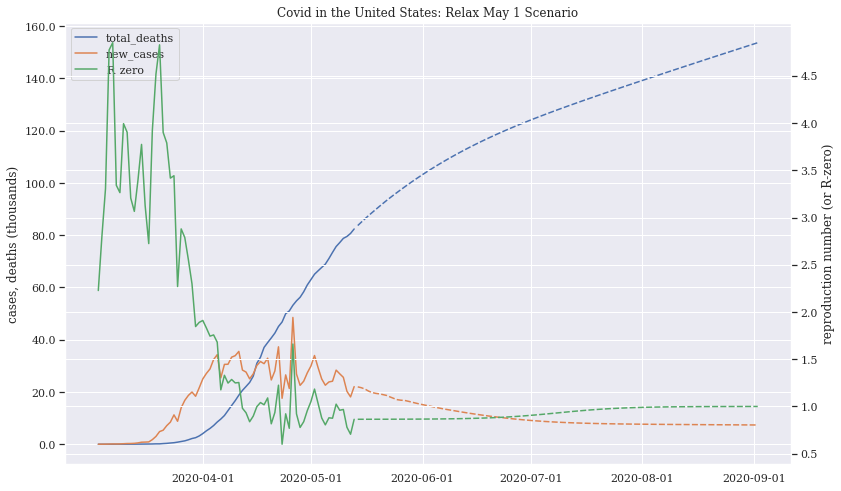

In [83]:
plot_cdr(US_Cov, 'Covid in the United States: Relax May 1 Scenario')

### Scenario: No Further Improvements on Today's Reproduction Number

In [84]:
US_Cov = forecast(US_Cov, 100)
no_improvements_scenario = US_Cov.copy()
no_improvements_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-15,Sat,3377.216223,2.297558e+06,0.006941,0.001471,471.209042,54031.176993,0.863706,203.099288,138170.694064,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-16,Sun,3310.222073,2.300868e+06,0.006951,0.001440,481.445802,52959.827601,0.863706,199.070389,138369.764452,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-17,Mon,3244.553138,2.304112e+06,0.006961,0.001409,491.890309,51909.652399,0.863706,195.121185,138564.885637,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-18,Tue,3180.183371,2.307293e+06,0.006971,0.001379,502.546776,50880.235500,0.863706,191.250111,138756.135749,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-19,Wed,3117.087206,2.310410e+06,0.006980,0.001350,513.419507,49871.168767,0.863706,187.455629,138943.591378,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-20,Thu,3055.239552,2.313465e+06,0.006989,0.001322,524.512899,48882.051920,0.863706,183.736230,139127.327608,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-21,Fri,2994.615805,2.316459e+06,0.006998,0.001294,535.831435,47912.492625,0.863706,180.090435,139307.418043,0.060138,NaN,NaN,forecast,331002647.0,North America


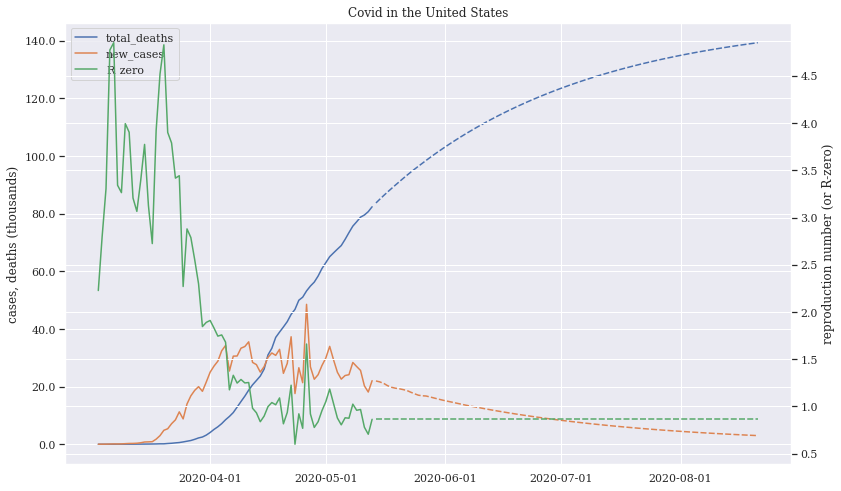

In [85]:
plot_cdr(US_Cov, 'Covid in the United States')

### Scenario: What if 90% of infections go unreported?

In [86]:
US_Cov = forecast(US_Cov, 100, R_zero_move=[0.7, 0.05, 0], R_zero_trailing=7, 
                  unreported=0.9)
unreported_scenario = US_Cov.copy()
unreported_scenario.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-08-15,Sat,184.041447,1.821995e+06,0.005504,0.000101,6861.752925,3695.128856,0.70045,11.067899,109571.277220,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-16,Sun,174.698915,1.822170e+06,0.005505,0.000096,7229.416789,3507.570859,0.70045,10.506057,109581.783277,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-17,Mon,165.830591,1.822336e+06,0.005506,0.000091,7616.744790,3329.531559,0.70045,9.972733,109591.756009,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-18,Tue,157.412432,1.822493e+06,0.005506,0.000086,8024.787513,3160.528095,0.70045,9.466481,109601.222490,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-19,Wed,149.421593,1.822642e+06,0.005506,0.000082,8454.652589,3000.101787,0.70045,8.985927,109610.208417,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-20,Thu,141.836374,1.822784e+06,0.005507,0.000078,8907.507715,2847.817109,0.70045,8.529767,109618.738184,0.060138,NaN,NaN,forecast,331002647.0,North America
2020-08-21,Fri,134.636172,1.822919e+06,0.005507,0.000074,9384.583600,2703.260677,0.70045,8.096760,109626.834945,0.060138,NaN,NaN,forecast,331002647.0,North America


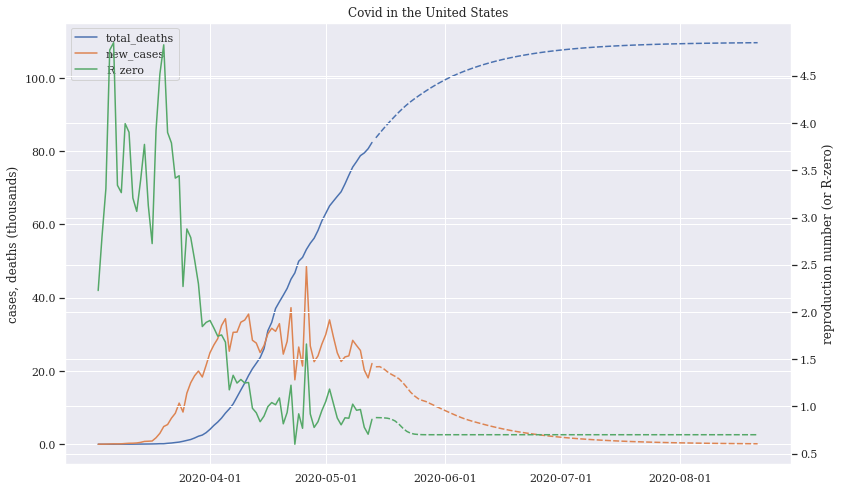

In [87]:
plot_cdr(unreported_scenario, 'Covid in the United States')

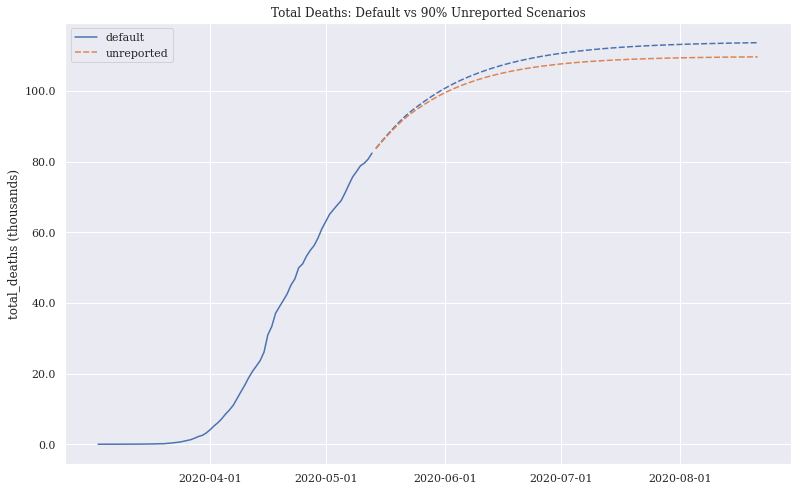

In [88]:
column = 'total_deaths'

unreported = unreported_scenario[unreported_scenario['source']=='forecast'][column]
default = default_scenario[[column,'source']]

compare = pd.concat([default, unreported], axis=1)
compare.columns = ['default','source','unreported']

plot_timeline(compare, 'Total Deaths: Default vs 90% Unreported Scenarios',
              date_freq='MS',
              left=['default','unreported'], right=None,
              left_ylabel=column + ' (thousands)')

### Scenario: What if we had done nothing since some date in the past?

In [89]:
cutoff = date(2020, 3, 15)
US_Cov_old = df[df['total_cases']>10].loc['United States'][:cutoff]
US_Cov_old[US_Cov_old['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-03-09,Mon,121,554,0.000002,0.246427,2.812790,519.0,3.263969,4,21,0.037906,NaN,NaN,actual,331002647.0,North America
2020-03-10,Tue,200,754,0.000002,0.308228,2.248815,701.0,3.994294,5,26,0.034483,NaN,NaN,actual,331002647.0,North America
2020-03-11,Wed,271,1025,0.000003,0.307056,2.257400,972.0,3.903292,2,28,0.027317,NaN,NaN,actual,331002647.0,North America
2020-03-12,Thu,287,1312,0.000004,0.246860,2.807854,1253.0,3.206704,2,30,0.022866,NaN,NaN,actual,331002647.0,North America
2020-03-13,Fri,351,1663,0.000005,0.237071,2.923802,1603.0,3.065502,10,40,0.024053,NaN,NaN,actual,331002647.0,North America
2020-03-14,Sat,511,2174,0.000007,0.267946,2.586895,2108.0,3.393738,7,47,0.021619,NaN,NaN,actual,331002647.0,North America
2020-03-15,Sun,777,2951,0.000009,0.305575,2.268335,2882.0,3.774462,10,57,0.019315,NaN,NaN,actual,331002647.0,North America


In [90]:
US_Cov_old = forecast(US_Cov_old, 100)
US_Cov_old.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-06-17,Wed,504.878783,3.247941e+08,0.981243,1.554459e-06,4.459089e+05,75608.278187,3.774462,9.751979,6.273556e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-18,Thu,382.344121,3.247945e+08,0.981244,1.177189e-06,5.888158e+05,57252.686825,3.774462,7.385163,6.273563e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-19,Fri,289.503751,3.247948e+08,0.981245,8.913440e-07,7.776427e+05,43348.241313,3.774462,5.591906,6.273569e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-20,Sat,219.184355,3.247950e+08,0.981246,6.748393e-07,1.027129e+06,32819.293439,3.774462,4.233652,6.273573e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-21,Sun,165.940335,3.247952e+08,0.981246,5.109078e-07,1.356697e+06,24848.586098,3.774462,3.205218,6.273577e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-22,Mon,125.635626,3.247953e+08,0.981247,3.868149e-07,1.791935e+06,18815.400593,3.774462,2.426713,6.273579e+06,0.019315,NaN,NaN,forecast,331002647.0,North America
2020-06-23,Tue,95.129629,3.247954e+08,0.981247,2.928910e-07,2.366570e+06,14248.740484,3.774462,1.837475,6.273581e+06,0.019315,NaN,NaN,forecast,331002647.0,North America


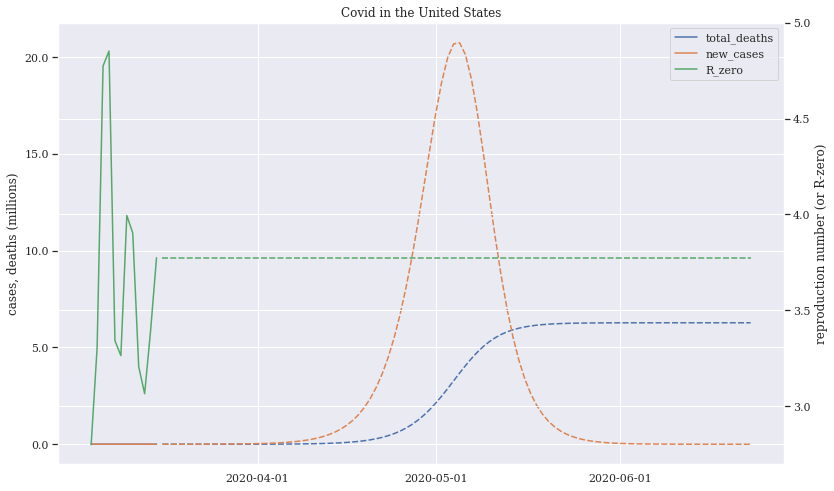

In [91]:
plot_cdr(US_Cov_old.iloc[30:], 'Covid in the United States',left_yscale=1e6,
         left_ylabel='cases, deaths (millions)')

## Other Countries

### China

In [92]:
China_Cov = df[df['total_cases']>100].loc['China']
China_Cov[China_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-07,Thu,2,83970,0.000058,0.000024,2.910144e+04,94.0,0.297872,0,4637,0.055222,NaN,NaN,actual,1.439324e+09,Asia
2020-05-08,Fri,6,83976,0.000058,0.000071,9.700941e+03,92.0,0.913043,0,4637,0.055218,NaN,NaN,actual,1.439324e+09,Asia
2020-05-09,Sat,0,83976,0.000058,0.000000,inf,77.0,0.000000,0,4637,0.055218,NaN,NaN,actual,1.439324e+09,Asia
2020-05-10,Sun,15,83991,0.000058,0.000179,3.880862e+03,82.0,2.560976,0,4637,0.055208,NaN,NaN,actual,1.439324e+09,Asia
2020-05-11,Mon,19,84010,0.000058,0.000226,3.064458e+03,98.0,2.714286,0,4637,0.055196,NaN,NaN,actual,1.439324e+09,Asia
2020-05-12,Tue,1,84011,0.000058,0.000012,5.823164e+04,73.0,0.191781,0,4637,0.055195,NaN,NaN,actual,1.439324e+09,Asia
2020-05-13,Wed,7,84018,0.000058,0.000083,8.319202e+03,78.0,1.256410,0,4637,0.055191,NaN,NaN,actual,1.439324e+09,Asia


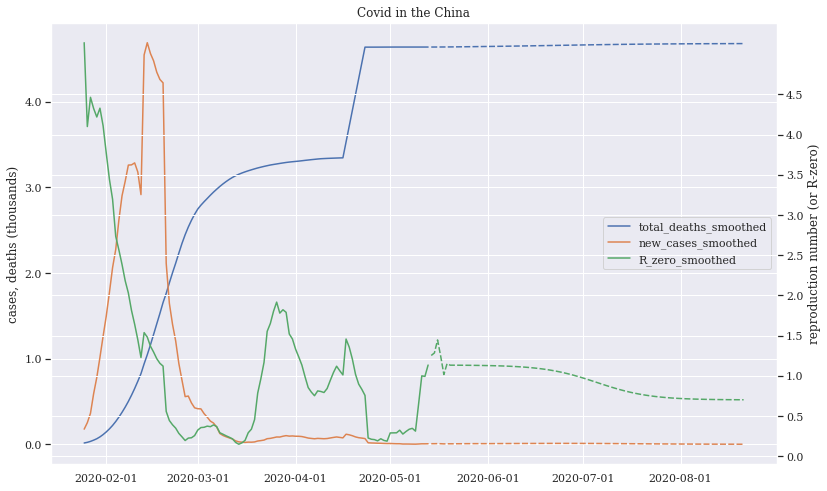

In [93]:
China_Cov = forecast(China_Cov, 100, R_zero_move=0.7, R_zero_trailing=7)

China_Cov['new_cases_smoothed']=China_Cov['new_cases'].rolling(7).mean()
China_Cov['total_deaths_smoothed']=China_Cov['total_deaths'].rolling(7).mean()
China_Cov['R_zero_smoothed']=China_Cov['R_zero'].rolling(7).mean()
plot_cdr(China_Cov, 'Covid in the China',
         left = ['total_deaths_smoothed', 'new_cases_smoothed'],
         right='R_zero_smoothed')

### Italy

In [94]:
Italy_Cov = df[df['total_cases']>100].loc['Italy']
Italy_Cov[Italy_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-07,Thu,1444,214457,0.003547,0.006756,102.596433,27130.0,0.745153,369,29684,0.138415,NaN,NaN,actual,60461828.0,Europe
2020-05-08,Fri,1401,215858,0.003570,0.006512,106.449170,25885.0,0.757736,274,29958,0.138786,NaN,NaN,actual,60461828.0,Europe
2020-05-09,Sat,1327,217185,0.003592,0.006129,113.097813,24191.0,0.767972,243,30201,0.139057,NaN,NaN,actual,60461828.0,Europe
2020-05-10,Sun,1083,218268,0.003610,0.004974,139.350137,22917.0,0.661605,194,30395,0.139255,NaN,NaN,actual,60461828.0,Europe
2020-05-11,Mon,802,219070,0.003623,0.003668,188.989565,21395.0,0.524796,165,30560,0.139499,NaN,NaN,actual,60461828.0,Europe
2020-05-12,Tue,744,219814,0.003636,0.003390,204.442820,20400.0,0.510588,179,30739,0.139841,NaN,NaN,actual,60461828.0,Europe
2020-05-13,Wed,1402,221216,0.003659,0.006358,109.021994,19711.0,0.995789,172,30911,0.139732,NaN,NaN,actual,60461828.0,Europe


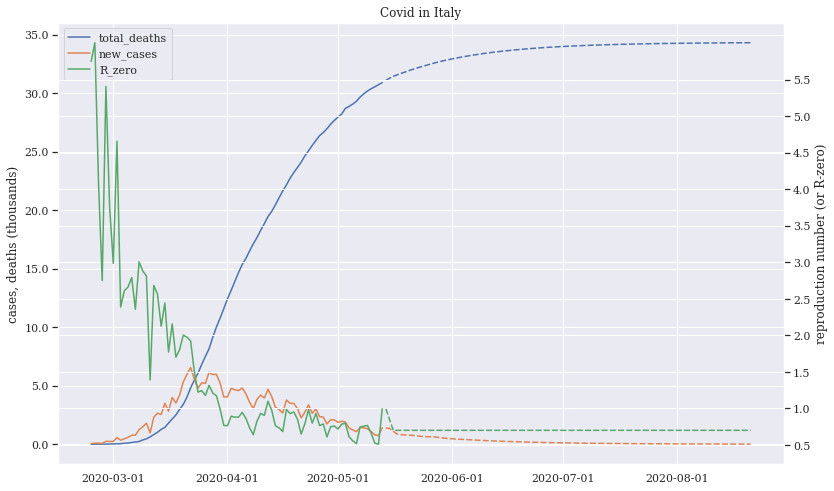

In [95]:
Italy_Cov = forecast(Italy_Cov, 100, R_zero_move=[0.7, 0.3])
plot_cdr(Italy_Cov, 'Covid in Italy')

### Sweden

In [96]:
Sweden_Cov = df[df['total_cases']>1000].loc['Sweden']
Sweden_Cov[Sweden_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-07,Thu,702,23918,0.002368,0.029790,23.268079,7914.0,1.241850,87,2941,0.122962,NaN,NaN,actual,10099270.0,Europe
2020-05-08,Fri,705,24623,0.002438,0.029050,23.860774,7868.0,1.254448,99,3040,0.123462,NaN,NaN,actual,10099270.0,Europe
2020-05-09,Sat,642,25265,0.002502,0.025739,26.929764,7698.0,1.167576,135,3175,0.125668,NaN,NaN,actual,10099270.0,Europe
2020-05-10,Sun,656,25921,0.002567,0.025633,27.040769,7744.0,1.185950,45,3220,0.124224,NaN,NaN,actual,10099270.0,Europe
2020-05-11,Mon,401,26322,0.002606,0.015352,45.151343,7682.0,0.730799,5,3225,0.122521,NaN,NaN,actual,10099270.0,Europe
2020-05-12,Tue,348,26670,0.002641,0.013134,52.774034,7744.0,0.629132,31,3256,0.122085,NaN,NaN,actual,10099270.0,Europe
2020-05-13,Wed,602,27272,0.002700,0.022321,31.053316,7651.0,1.101555,57,3313,0.121480,NaN,NaN,actual,10099270.0,Europe


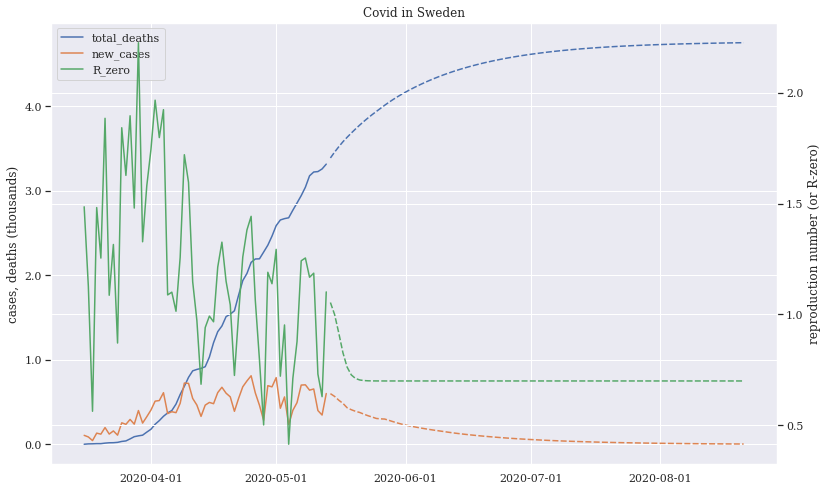

In [97]:
Sweden_Cov = forecast(Sweden_Cov, 100, R_zero_move=[0.7, 0.05,-4])
plot_cdr(Sweden_Cov, 'Covid in Sweden')

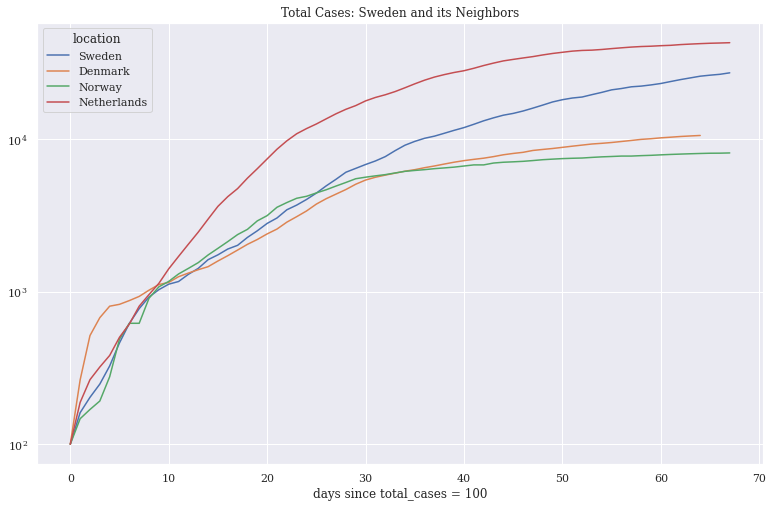

In [98]:
plot_growth(df[df['source']=='actual'], 
            ['Sweden','Denmark','Norway','Netherlands'], 
            title='Total Cases: Sweden and its Neighbors',logy=True, 
            start=100, column='total_cases')

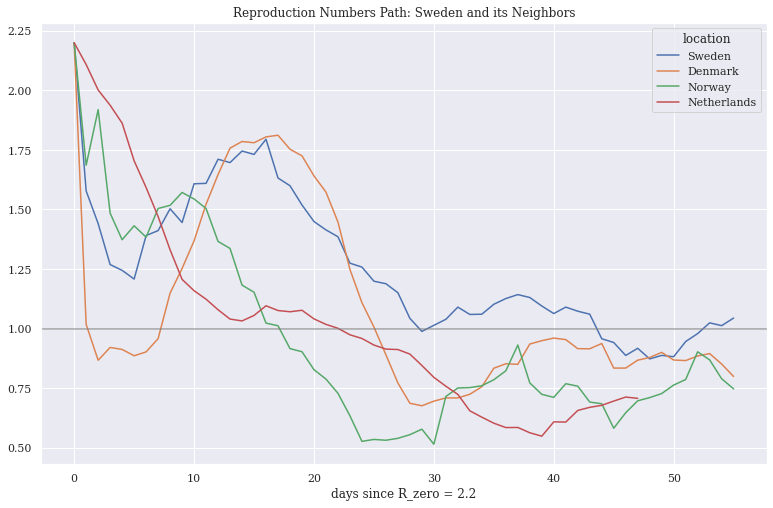

In [99]:
plot_growth(df[df['source']=='actual'],
            locations=['Sweden','Denmark','Norway','Netherlands'], 
            column='R_zero', start=2.2, rolling=7, ascending=False, 
            logy=False, min_cases=100, hline=1,
            title='Reproduction Numbers Path: Sweden and its Neighbors')

What if the United States had followed Sweden's path since Swedens maximum R-zero?

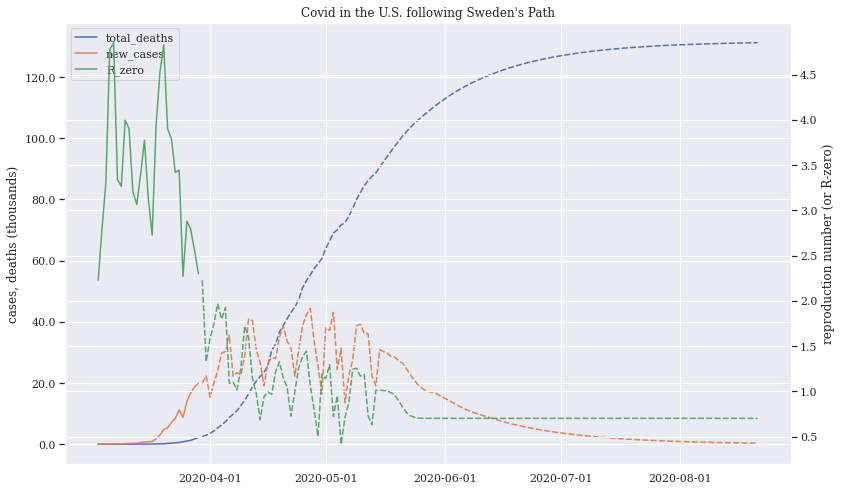

In [100]:
forecast_days=100
cutoff = Sweden_Cov['R_zero'].idxmax(axis=1).date()

US_Cov_Sweden_path = df[df['total_cases']>10].loc['United States'][:cutoff]

new_R_zeros = Sweden_Cov[cutoff:]['R_zero']
new_fatality = US_Cov[cutoff:]['fatality']

last_actual = US_Cov[US_Cov['source']=='actual'].index.max().date()

stage_1 = (last_actual - cutoff).days # days from cutoff until today
US_Cov_Sweden_path = forecast(US_Cov_Sweden_path, stage_1, 
                              new_R_zeros=new_R_zeros,
                              new_fatality=new_fatality)

stage_2 = forecast_days   # days of forward forecast
US_Cov_Sweden_path = forecast(US_Cov_Sweden_path, stage_2, replace=False,
                              R_zero_move=[0.7, 0.05, 0], R_zero_trailing=7)

plot_cdr(US_Cov_Sweden_path.iloc[29:], 'Covid in the U.S. following Sweden\'s Path')

## The World, Country and Regional Comparisons

In [101]:
World_Cov = df.copy()
World_Cov = World_Cov[['new_cases','total_cases','new_deaths',
                       'total_deaths','population']].groupby(level=1).sum()
World_Cov['location']='world'
World_Cov.reset_index(inplace=True)
World_Cov.rename(columns = {'index':'date'}, inplace = True) 
World_Cov = munge_data(World_Cov, case_start=10, contagious_days=14)
World_Cov = order_columns(World_Cov).loc['world']
World_Cov[World_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-07,Thu,90027,3714120,0.000479,0.024538,28.248228,1134992.0,1.110473,6387,263494,0.070944,NaN,NaN,actual,7.748173e+09,NaN
2020-05-08,Fri,94422,3808542,0.000492,0.025105,27.610293,1151327.0,1.148160,5748,269242,0.070694,NaN,NaN,actual,7.748173e+09,NaN
2020-05-09,Sat,90117,3898659,0.000503,0.023386,29.639142,1168138.0,1.080042,5268,274510,0.070411,NaN,NaN,actual,7.748173e+09,NaN
2020-05-10,Sun,87552,3986211,0.000514,0.022209,31.210885,1154157.0,1.062011,4440,278950,0.069979,NaN,NaN,actual,7.748173e+09,NaN
2020-05-11,Mon,79637,4065848,0.000525,0.019781,35.040747,1150567.0,0.969016,3410,282360,0.069447,NaN,NaN,actual,7.748173e+09,NaN
2020-05-12,Tue,71144,4136992,0.000534,0.017347,39.958625,1156146.0,0.861497,3569,285929,0.069115,NaN,NaN,actual,7.748173e+09,NaN
2020-05-13,Wed,85359,3994321,0.000519,-0.035095,-19.750399,940613.0,1.270476,5583,264592,0.066242,NaN,NaN,actual,7.701418e+09,NaN


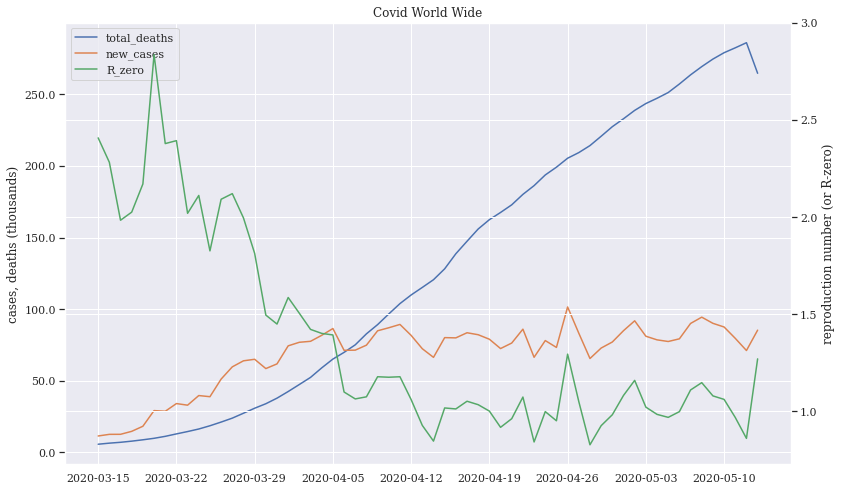

In [102]:
plot_cdr(World_Cov[World_Cov['source']=='actual'][-60:], 
         'Covid World Wide','W')

In [103]:
df[df['source']=='actual'].groupby('location')[['growth','days_to_dbl']]\
    .last().sort_values('growth',ascending=False).head(10)

,growth,days_to_dbl
location,,
Mauritania,0.980829,0.706695
Zambia,0.501796,1.381332
Nepal,0.482058,1.437893
Nicaragua,0.446287,1.553142
Burundi,0.351398,1.972542
South Sudan,0.218002,3.179543
Yemen,0.179341,3.864969
Chad,0.103184,6.717569
Kuwait,0.101400,6.835737


In [104]:
df[df['source']=='actual'].groupby('location')[['region','total_cases']]\
    .last().groupby('region').sum()\
    .sort_values('total_cases',ascending=False)

,total_cases
region,
Europe,1596104
North America,1510051
Asia,702719
South America,335587
Africa,69504
Oceania,8386


In [105]:
top5 = df[df['source']=='actual']\
    .groupby('location')[['total_cases','R_zero']]\
    .last().sort_values('total_cases', ascending=False).head(5).reset_index()
top5.index += 1
top5

,location,total_cases,R_zero
1,United States,1369964,0.863706
2,Russia,232243,1.100234
3,Spain,228030,0.481891
4,United Kingdom,226463,0.729385
5,Italy,221216,0.995789


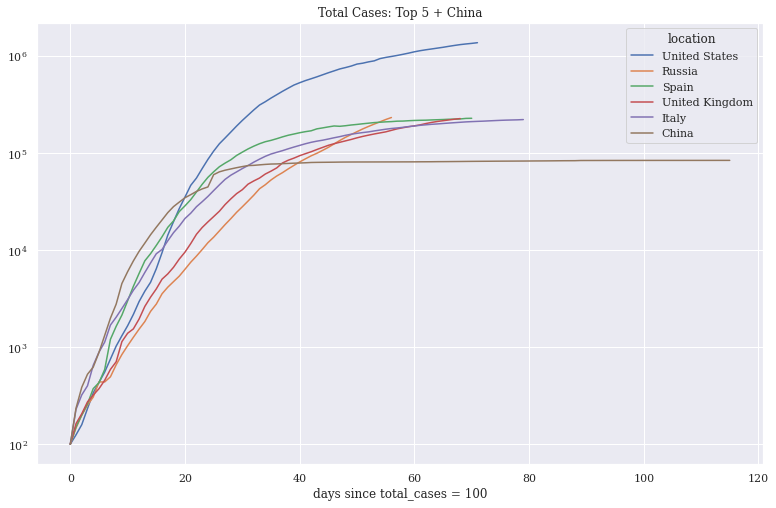

In [106]:
plot_growth(df[df['source']=='actual'], 
            locations=top5['location'].append(pd.Series('China', index=[6])), 
            title='Total Cases: Top 5 + China', 
            start=100, rolling=1, ascending=True, logy=True)

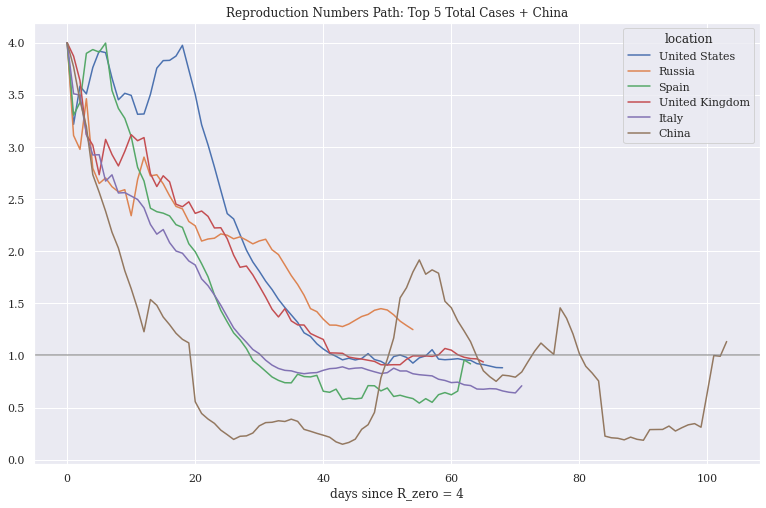

In [107]:
plot_growth(df[df['source']=='actual'],
            locations=top5['location'].append(pd.Series('China', index=[6])), 
            column='R_zero', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100, hline=1,
            title='Reproduction Numbers Path: Top 5 Total Cases + China')

## U.S. States

### Oklahoma

In [108]:
OK_Cov = df_states[df_states['total_cases']>10].loc['Oklahoma']
OK_Cov[OK_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-05,Tue,83.0,4127,0.001043,0.020316,34.117535,1320.0,0.880303,9.0,247,0.059850,NaN,NaN,actual,3956971,NA
2020-05-06,Wed,74.0,4201,0.001062,0.017772,39.002553,1307.0,0.792655,6.0,253,0.060224,NaN,NaN,actual,3956971,NA
2020-05-07,Thu,129.0,4330,0.001094,0.030245,22.917782,1313.0,1.375476,7.0,260,0.060046,NaN,NaN,actual,3956971,NA
2020-05-08,Fri,94.0,4424,0.001118,0.021477,32.274347,1304.0,1.009202,6.0,266,0.060127,NaN,NaN,actual,3956971,NA
2020-05-09,Sat,66.0,4490,0.001135,0.014808,46.807584,1297.0,0.712413,4.0,270,0.060134,NaN,NaN,actual,3956971,NA
2020-05-10,Sun,99.0,4589,0.001160,0.021809,31.781989,1336.0,1.037425,2.0,272,0.059272,NaN,NaN,actual,3956971,NA
2020-05-11,Mon,24.0,4613,0.001166,0.005216,132.881789,1333.0,0.252063,2.0,274,0.059397,NaN,NaN,actual,3956971,NA


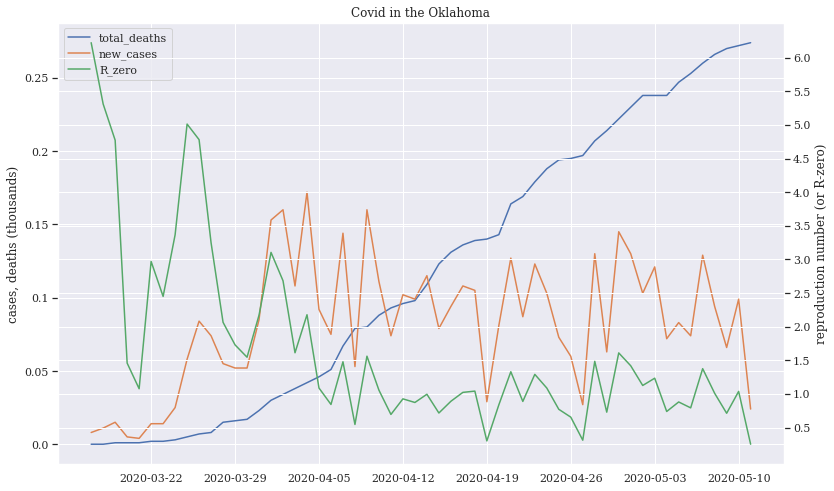

In [109]:
plot_cdr(OK_Cov[OK_Cov['source']=='actual'], 
         'Covid in the Oklahoma','W')

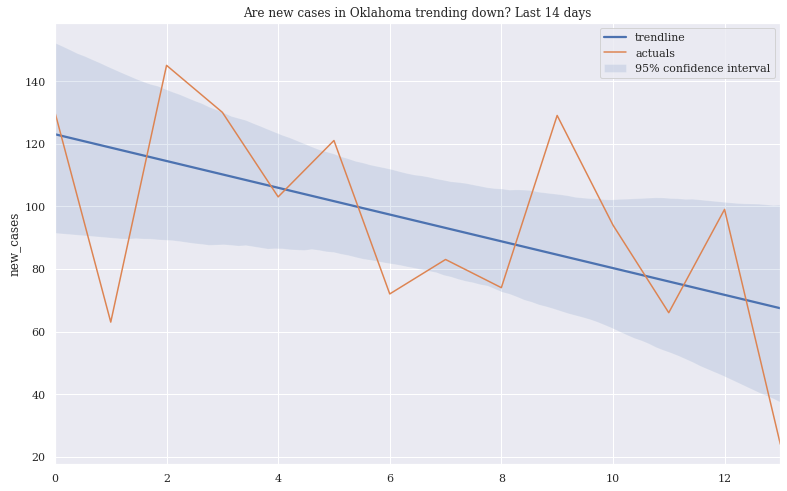

In [110]:
last = 14
OK_last_days = OK_Cov[OK_Cov['source']=='actual'][-last:]
order = 1
x = [a for a in range(last)]
y_col = 'new_cases'

ax0 = sns.regplot(x=x, y=y_col, data=OK_last_days, label='trendline', 
            fit_reg=True, order=order, scatter=False) 
ax0.collections[0].set_label('95% confidence interval')

ax1 = sns.lineplot(x=x, y=y_col, data=OK_last_days, label='actuals')

plt.legend()
plt.title('Are new cases in Oklahoma trending down? Last ' + str(last) + ' days')
plt.show()

In [111]:
OK_Cov = forecast(OK_Cov, 50, R_zero_move=(0.7, 0.05), R_zero_trailing=7)
OK_Cov.tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-06-24,Wed,10.592723,6049.478874,0.001529,0.001753,395.508031,202.462220,0.70041,0.629180,359.323046,0.059397,NaN,NaN,forecast,3956971,NA
2020-06-25,Thu,10.113549,6059.592423,0.001531,0.001670,414.956550,193.344061,0.70041,0.600718,359.923764,0.059397,NaN,NaN,forecast,3956971,NA
2020-06-26,Fri,9.658047,6069.250470,0.001534,0.001593,435.236629,184.679912,0.70041,0.573662,360.497427,0.059397,NaN,NaN,forecast,3956971,NA
2020-06-27,Sat,9.225227,6078.475697,0.001536,0.001519,456.366028,176.440438,0.70041,0.547954,361.045381,0.059397,NaN,NaN,forecast,3956971,NA
2020-06-28,Sun,8.813624,6087.289321,0.001538,0.001449,478.388017,168.598247,0.70041,0.523506,361.568887,0.059397,NaN,NaN,forecast,3956971,NA
2020-06-29,Mon,8.421869,6095.711190,0.001540,0.001383,501.350184,161.127229,0.70041,0.500237,362.069123,0.059397,NaN,NaN,forecast,3956971,NA
2020-06-30,Tue,8.048657,6103.759847,0.001543,0.001320,525.306731,154.000346,0.70041,0.478069,362.547192,0.059397,NaN,NaN,forecast,3956971,NA


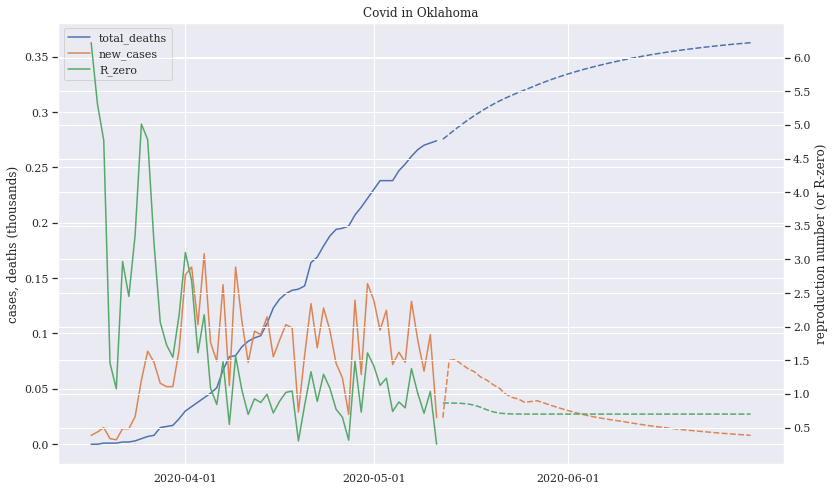

In [112]:
plot_cdr(OK_Cov, 'Covid in Oklahoma')

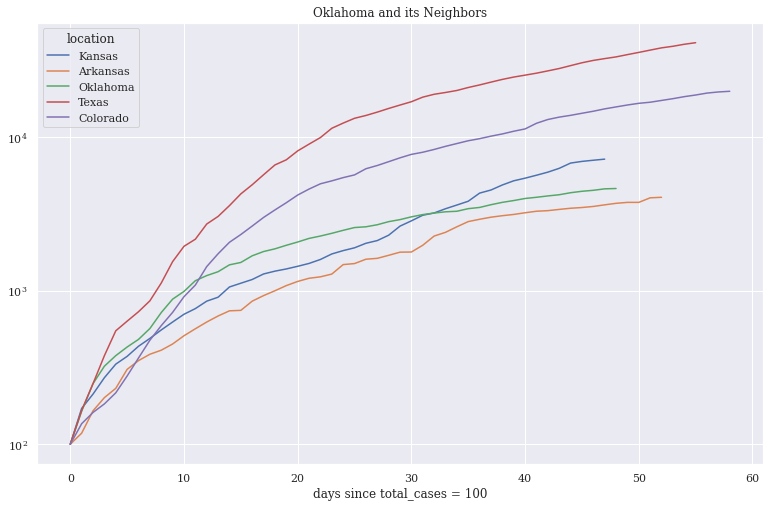

In [113]:
plot_growth(df_states, 
            ['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'],
            title='Oklahoma and its Neighbors', logy=True, 
            start=100, column='total_cases')

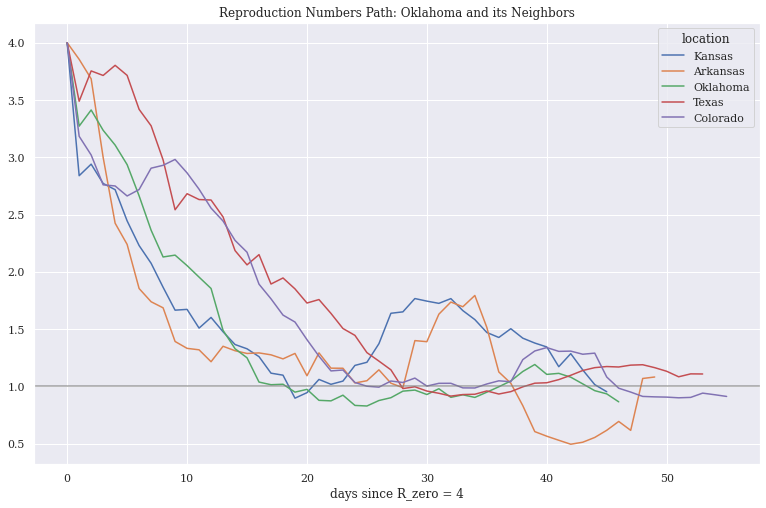

In [114]:
plot_growth(df_states[df_states['source']=='actual'],
            locations=['Kansas', 'Arkansas','Oklahoma','Texas','Colorado'], 
            column='R_zero', start=4, rolling=7, ascending=False, 
            logy=False, min_cases=100, hline=1,
            title='Reproduction Numbers Path: Oklahoma and its Neighbors')

### New York

In [115]:
NY_Cov = df_states[df_states['total_cases']>10].loc['New York']
NY_Cov[NY_Cov['source']=='actual'].tail(7)

,day,new_cases,total_cases,prevalence,growth,days_to_dbl,contagious,R_zero,new_deaths,total_deaths,fatality,total_tests,new_tests,source,population,region
2020-05-05,Tue,2302.0,326659,0.016792,0.007072,98.012169,70727.0,0.455668,240.0,25028,0.076618,NaN,NaN,actual,19453561,NA
2020-05-06,Wed,2746.0,329405,0.016933,0.008371,82.801576,67814.0,0.566904,928.0,25956,0.078797,NaN,NaN,actual,19453561,NA
2020-05-07,Thu,3526.0,332931,0.017114,0.010647,65.100963,64999.0,0.759458,250.0,26206,0.078713,NaN,NaN,actual,19453561,NA
2020-05-08,Fri,2873.0,335804,0.017262,0.008592,80.669845,59586.0,0.675024,152.0,26358,0.078492,NaN,NaN,actual,19453561,NA
2020-05-09,Sat,2715.0,338519,0.017401,0.008053,86.077820,51618.0,0.736371,226.0,26584,0.078530,NaN,NaN,actual,19453561,NA
2020-05-10,Sun,2138.0,340657,0.017511,0.006296,110.095270,47743.0,0.626940,214.0,26798,0.078666,NaN,NaN,actual,19453561,NA
2020-05-11,Mon,1610.0,342267,0.017594,0.004715,147.008065,45276.0,0.497835,205.0,27003,0.078895,NaN,NaN,actual,19453561,NA


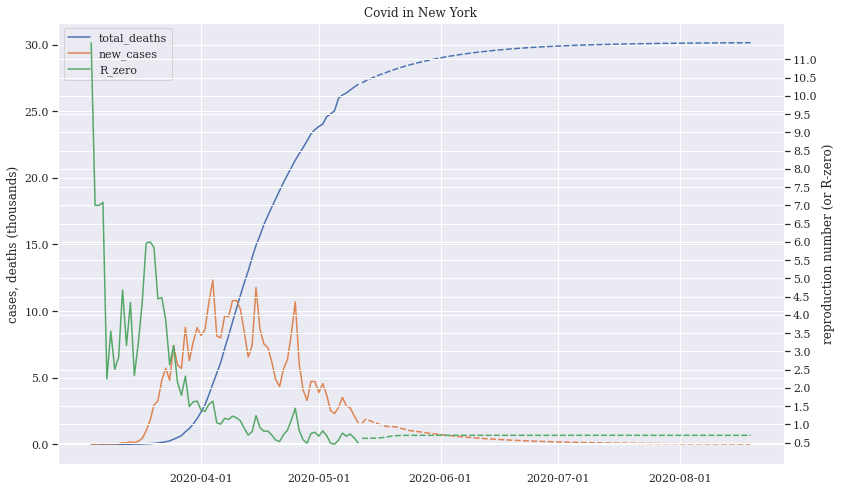

In [116]:
NY_Cov = forecast(NY_Cov, 100, R_zero_move=(0.7,0.05), R_zero_trailing=7)
plot_cdr(NY_Cov, 'Covid in New York')

## More on Reproduction Numbers

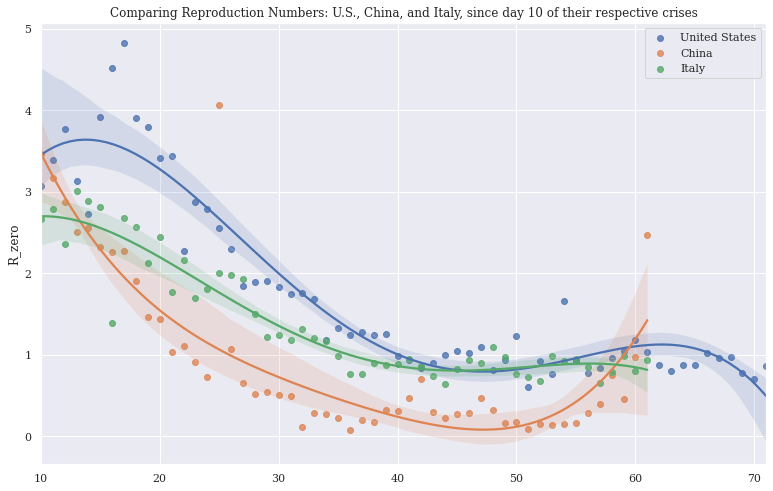

In [117]:
order = 4
day_start = 10

US_ = US_Cov[US_Cov['source']=='actual'].copy()
US_.reset_index(inplace=True)
US_ = US_[day_start:]
days = len(US_)

China_ = China_Cov[China_Cov['source']=='actual'][:days].copy()
China_.reset_index(inplace=True)
China_ = China_[day_start:]

Italy_ = Italy_Cov[Italy_Cov['source']=='actual'][:days].copy()
Italy_.reset_index(inplace=True)
Italy_ = Italy_[day_start:]

sns.regplot(x=US_.index, y='R_zero', data=US_, label='United States', 
            fit_reg=True, order=order) 
sns.regplot(x=China_.index, y='R_zero', data=China_,  label='China',
            fit_reg=True, order=order) 
sns.regplot(x=China_.index, y='R_zero', data=Italy_, label='Italy',
            fit_reg=True, order=order) 

plt.legend()
plt.title('Comparing Reproduction Numbers: U.S., China, and Italy, since day '
          + str(day_start) + ' of their respective crises')
plt.show()

#### First stab at an ARIMA model of the U.S. reproduction number. 

Following steps in https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/

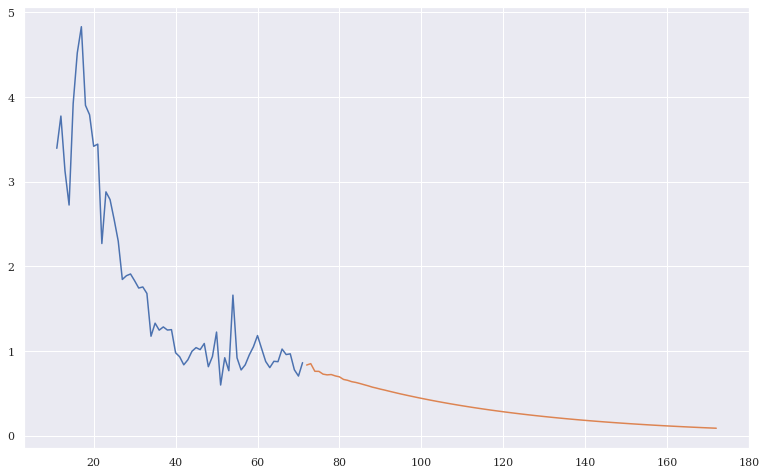

In [118]:
from statsmodels.tsa.arima_model import ARIMA

actuals = np.log(US_.R_zero)[1:]

# fit model
model = ARIMA(actuals, order=(7, 1, 1))
model_fit = model.fit(disp=False)

# make prediction
prediction = model_fit.predict(len(actuals), len(actuals)+100, typ='levels')

# plot results
sns.lineplot(data=np.exp(actuals))
sns.lineplot(data=np.exp(prediction))

In [119]:
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:               D.R_zero   No. Observations:                   60
Model:                 ARIMA(7, 1, 1)   Log Likelihood                  16.765
Method:                       css-mle   S.D. of innovations              0.182
Date:                Wed, 13 May 2020   AIC                            -13.530
Time:                        14:39:43   BIC                              7.414
Sample:                             1   HQIC                            -5.338
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -0.0222      0.013     -1.656      0.104      -0.048       0.004
ar.L1.D.R_zero     0.1464      0.270      0.542      0.590      -0.383       0.676
ar.L2.D.R_zero     0.0803      0.181

Plot time series of residuals to check if stationary.

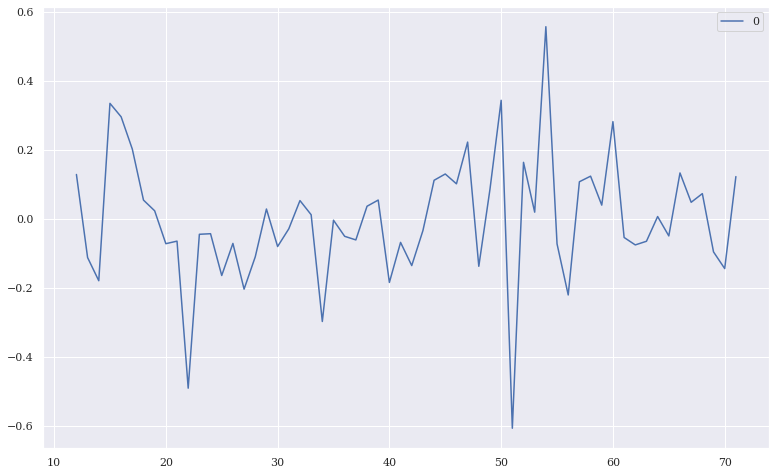

In [120]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()

Plot histogram of residuals to check if normally distributed.

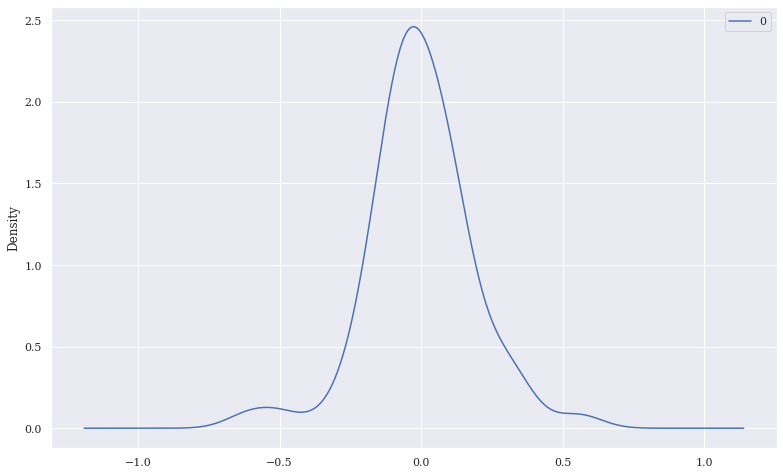

In [121]:
residuals.plot(kind='kde')

## Case Fatality Rates


In [122]:
from scipy import stats
import statsmodels.api as sm

CFR_df = df.groupby('location')[['total_cases','total_deaths',
                                   'prevalence','population']].last()
CFR_df = CFR_df[(CFR_df['total_cases']>0) & (CFR_df['total_deaths']>0)]
CFR_df['log_cases'] = np.log10(CFR_df['total_cases'])
CFR_df['log_deaths'] = np.log10(CFR_df['total_deaths'])
CFR_df['CFR'] = CFR_df['total_deaths']/CFR_df['total_cases']
CFR_df

,total_cases,total_deaths,prevalence,population,log_cases,log_deaths,CFR
location,,,,,,,
Afghanistan,4967,127,0.000128,38928341.0,3.696094,2.103804,0.025569
Albania,876,31,0.000304,2877800.0,2.942504,1.491362,0.035388
Algeria,6067,515,0.000138,43851043.0,3.782974,2.711807,0.084885
Andorra,758,48,0.009810,77265.0,2.879669,1.681241,0.063325
Angola,45,2,0.000001,32866268.0,1.653213,0.301030,0.044444
...,...,...,...,...,...,...,...
Uzbekistan,2547,10,0.000076,33469199.0,3.406029,1.000000,0.003926
Venezuela,423,10,0.000015,28435943.0,2.626340,1.000000,0.023641
Yemen,67,11,0.000002,29825968.0,1.826075,1.041393,0.164179


/usr/local/lib/python3.6/dist-packages/seaborn/axisgrid.py:1840: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


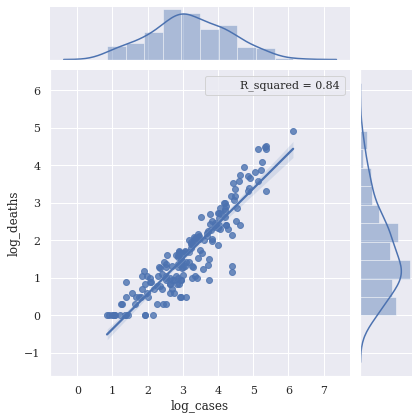

In [123]:
def R_squared(x, y):
    return stats.pearsonr(x, y)[0] ** 2

sns.jointplot(x='log_cases', y='log_deaths', data=CFR_df, 
                    stat_func=R_squared, kind='reg')
plt.show()

In [124]:
results = sm.OLS(endog=CFR_df['total_deaths'], exog=CFR_df[['total_cases']], 
                 missing='drop').fit()
print(results.summary())

                                 OLS Regression Results                                
Dep. Variable:           total_deaths   R-squared (uncentered):                   0.870
Model:                            OLS   Adj. R-squared (uncentered):              0.870
Method:                 Least Squares   F-statistic:                              1174.
Date:                Wed, 13 May 2020   Prob (F-statistic):                    1.57e-79
Time:                        14:39:45   Log-Likelihood:                         -1647.7
No. Observations:                 176   AIC:                                      3297.
Df Residuals:                     175   BIC:                                      3300.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------

In [125]:
results = sm.WLS(endog=CFR_df['total_deaths'], exog=CFR_df[['total_cases']], 
                 weights=CFR_df['population'], missing='drop').fit()
print(results.summary())

                                 WLS Regression Results                                
Dep. Variable:           total_deaths   R-squared (uncentered):                   0.959
Model:                            WLS   Adj. R-squared (uncentered):              0.958
Method:                 Least Squares   F-statistic:                              3977.
Date:                Wed, 13 May 2020   Prob (F-statistic):                   7.96e-121
Time:                        14:39:45   Log-Likelihood:                         -1834.7
No. Observations:                 173   AIC:                                      3671.
Df Residuals:                     172   BIC:                                      3675.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------